# **NammaMetro Ridership Data Analysis**

**Last Major Update:** 2025-04-05

**Author:** Mahesh Shantaram <<ms@thecontrarian.in>>

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm, linregress, t
from IPython.display import Markdown

filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename)

_____
## **One Day on NammaMetro**

**Earliest Record**

In [278]:
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460,352496,853,43,68,241883,7444,512,177279,49351,95571,32357


**Latest Record**

In [279]:
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
131,04-04-2025,419016,418537,136,36,307,202926,10892,249,169503,47705,91362,30436


Let's create two additional useful features: `Day of Week` and `Total Riders`

In [280]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 
                                'Total Tokens', 
                                'Total NCMC', 
                                'Group Ticket', 
                                'Total QR']].sum(axis=1).astype('Int64')
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

### **Missing Days**

In [281]:
number_of_days = 180

date_range = pd.date_range(start=df['Record Date'].min(), 
                          end=df['Record Date'].max(), 
                          freq='D')
complete_df = pd.DataFrame({'Record Date': date_range})
complete_df = complete_df.merge(df, on='Record Date', how='left')
complete_df['Formatted_Date'] = complete_df['Record Date'].dt.strftime('%b %d')

print("="*40)
print(f"Missing Data – Last 10 Dates")
print("="*40)
missing_data = complete_df.tail(number_of_days)
missing_data['Day of Week'] = missing_data['Record Date'].dt.day_name()
missing_data = missing_data[missing_data['Total Riders'].isna()][['Record Date', 'Day of Week', 'Total Riders']]
display(missing_data.tail(10))

# For use later when creating the stacked area chart
imputed_days = missing_data['Record Date'].dt.strftime('%Y-%m-%d').tolist()

Missing Data – Last 10 Dates


,Record Date,Day of Week,Total Riders
137,2025-03-12,Wednesday,<NA>
138,2025-03-13,Thursday,<NA>
141,2025-03-16,Sunday,<NA>
142,2025-03-17,Monday,<NA>
150,2025-03-25,Tuesday,<NA>
152,2025-03-27,Thursday,<NA>
153,2025-03-28,Friday,<NA>
157,2025-04-01,Tuesday,<NA>
158,2025-04-02,Wednesday,<NA>
159,2025-04-03,Thursday,<NA>


### **The Dataset at a Glance** 

In [282]:
def plot_total_ridership(df, end_date=None, number_of_days=28, base_value=0):
    end_date = df['Record Date'].max() if end_date == None else pd.to_datetime(end_date)
    if end_date > df['Record Date'].max():
        end_date = df['Record Date'].max()
    start_date = end_date - pd.Timedelta(days=number_of_days-1)
    if start_date < df['Record Date'].min():
        start_date = df['Record Date'].min()
    date_range = pd.date_range(start=start_date, end=end_date)

    complete_df = df[['Record Date', 'Total Riders']].copy()
    complete_df = complete_df.set_index('Record Date').reindex(date_range).reset_index().rename(columns={'index': 'Record Date'})
    complete_df['Record Date'] = complete_df['Record Date'].dt.strftime('%a %d %b')
    
    ax = complete_df\
        .plot(x='Record Date',
            y='Total Riders',
            kind='bar',
            xlabel='',
            ylabel='',
            figsize=(25,8),
            width=1.25,
            color=sns.color_palette('Purples_d', 7),
            legend=False,
            rot=90)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(bottom=base_value)
    plt.title(f"{start_date.strftime('%b %d, %Y')} >>    Total Daily Ridership    << {end_date.strftime('%b %d, %Y')}",
              fontsize=16, y=1.05, fontweight='bold')
    if len(complete_df) > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    plt.grid(True, axis='y', alpha=0.4)
    plt.show()

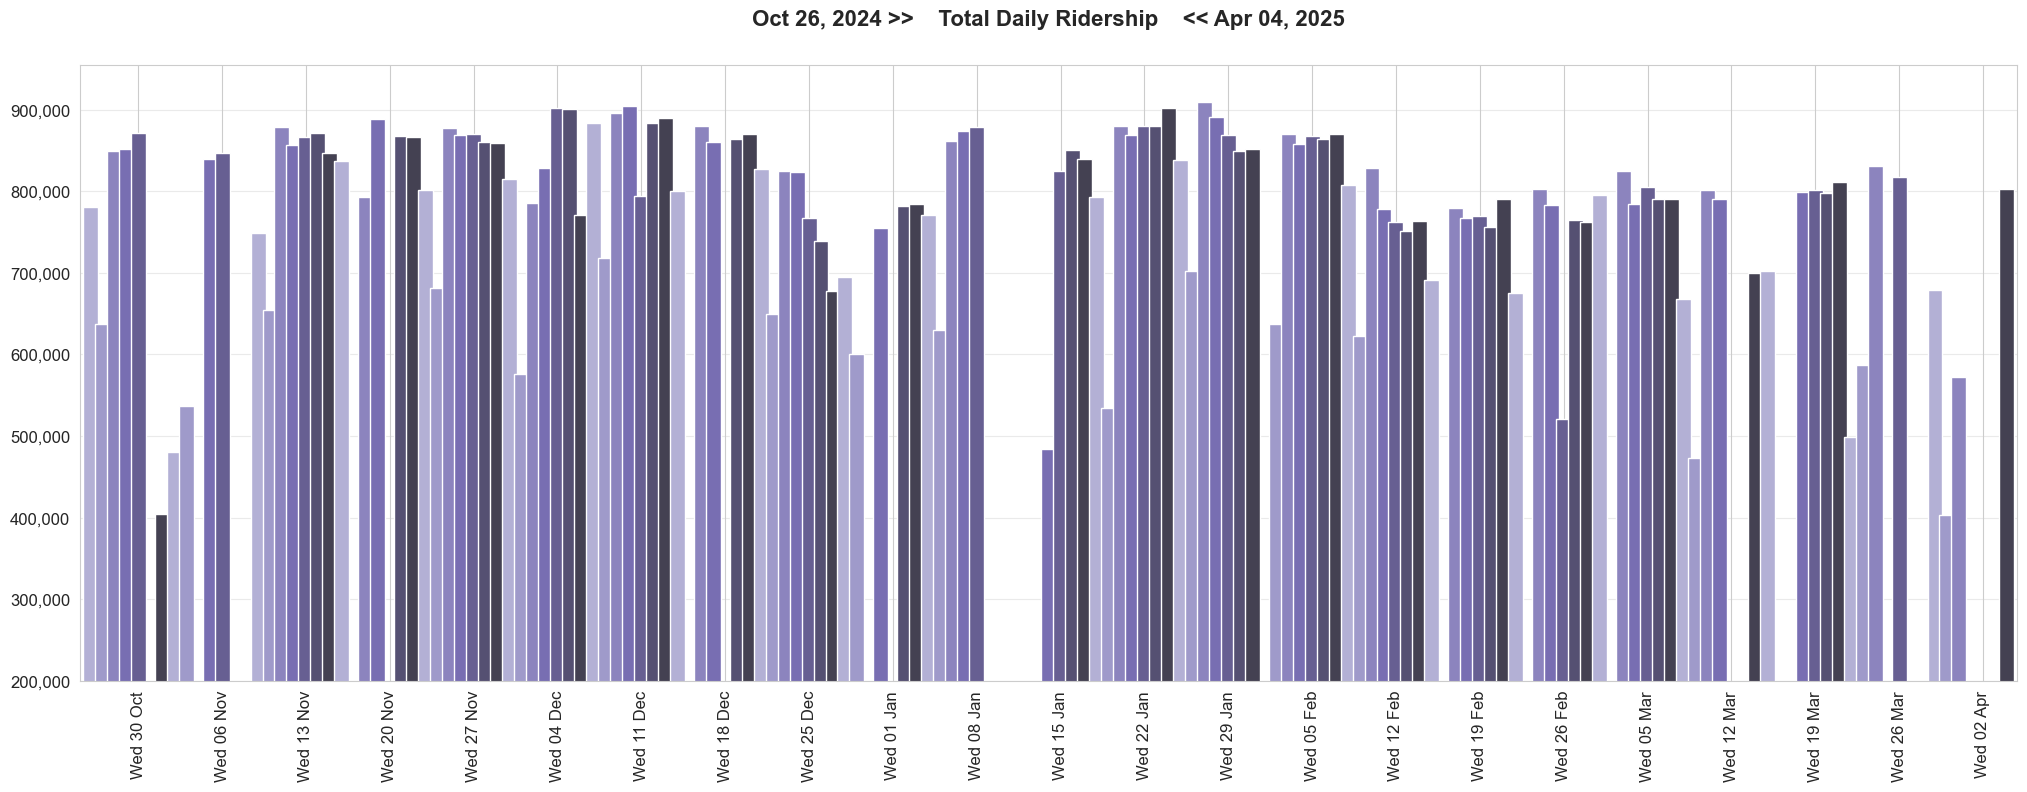

In [283]:
plot_total_ridership(df, number_of_days=180, base_value=200000)

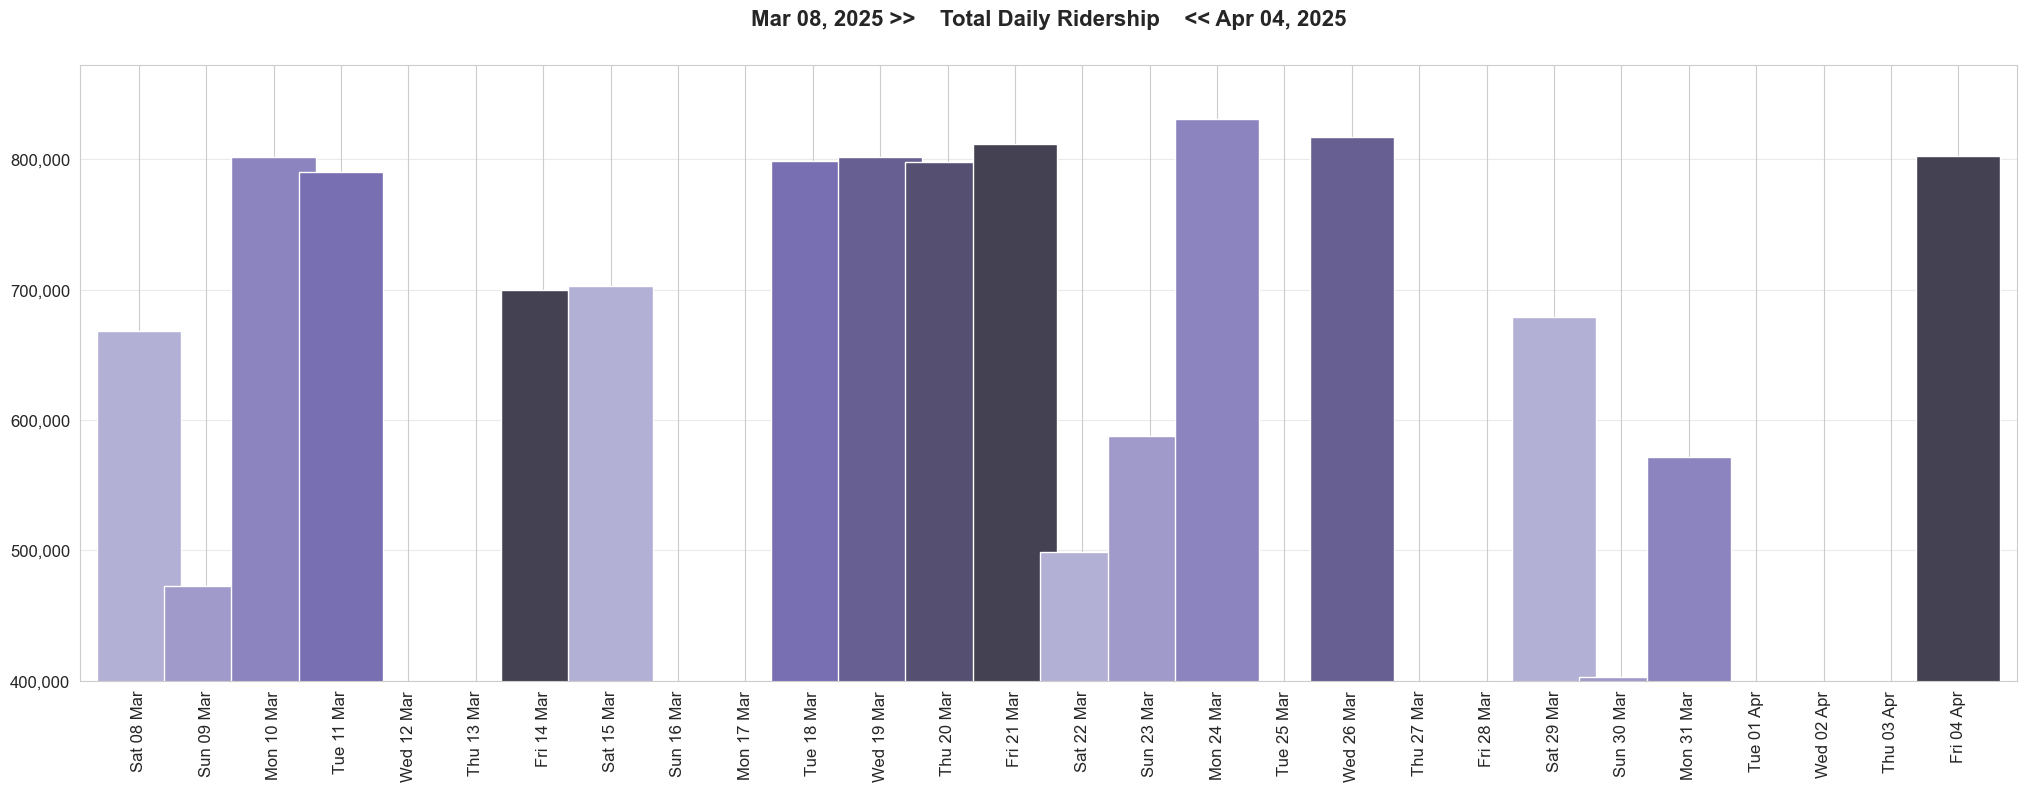

In [284]:
plot_total_ridership(df, number_of_days=7*4, base_value=400000)

_____
## **“The Metro is Getting Crowded!”**

### **Top 10 Busiest Days - The Commuters**

In [285]:
busiest_days = df[['Record Date', 'Day of Week', 'Total Riders']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(10)

,Record Date,Day of Week,Total Riders
1,2025-01-27,Monday,909522
2,2024-12-10,Tuesday,903928
3,2025-01-24,Friday,902476
4,2024-12-04,Wednesday,901475
5,2024-12-05,Thursday,901230
6,2024-12-09,Monday,895461
7,2025-01-28,Tuesday,891111
8,2024-12-13,Friday,890143
9,2024-11-19,Tuesday,889113
10,2024-12-07,Saturday,883300


### **Least Busy Days so far - The Weekenders**

In [286]:
busiest_days.tail(10)

,Record Date,Day of Week,Total Riders
123,2025-03-31,Monday,571849
124,2024-11-03,Sunday,536524
125,2025-01-19,Sunday,534139
126,2025-02-26,Wednesday,520284
127,2025-03-22,Saturday,498494
128,2025-01-14,Tuesday,484293
129,2024-11-02,Saturday,480284
130,2025-03-09,Sunday,473005
131,2024-11-01,Friday,404342
132,2025-03-30,Sunday,402795


_____
## **One Week on NammaMetro**

### **Total Daily Ridership by Day of Week**

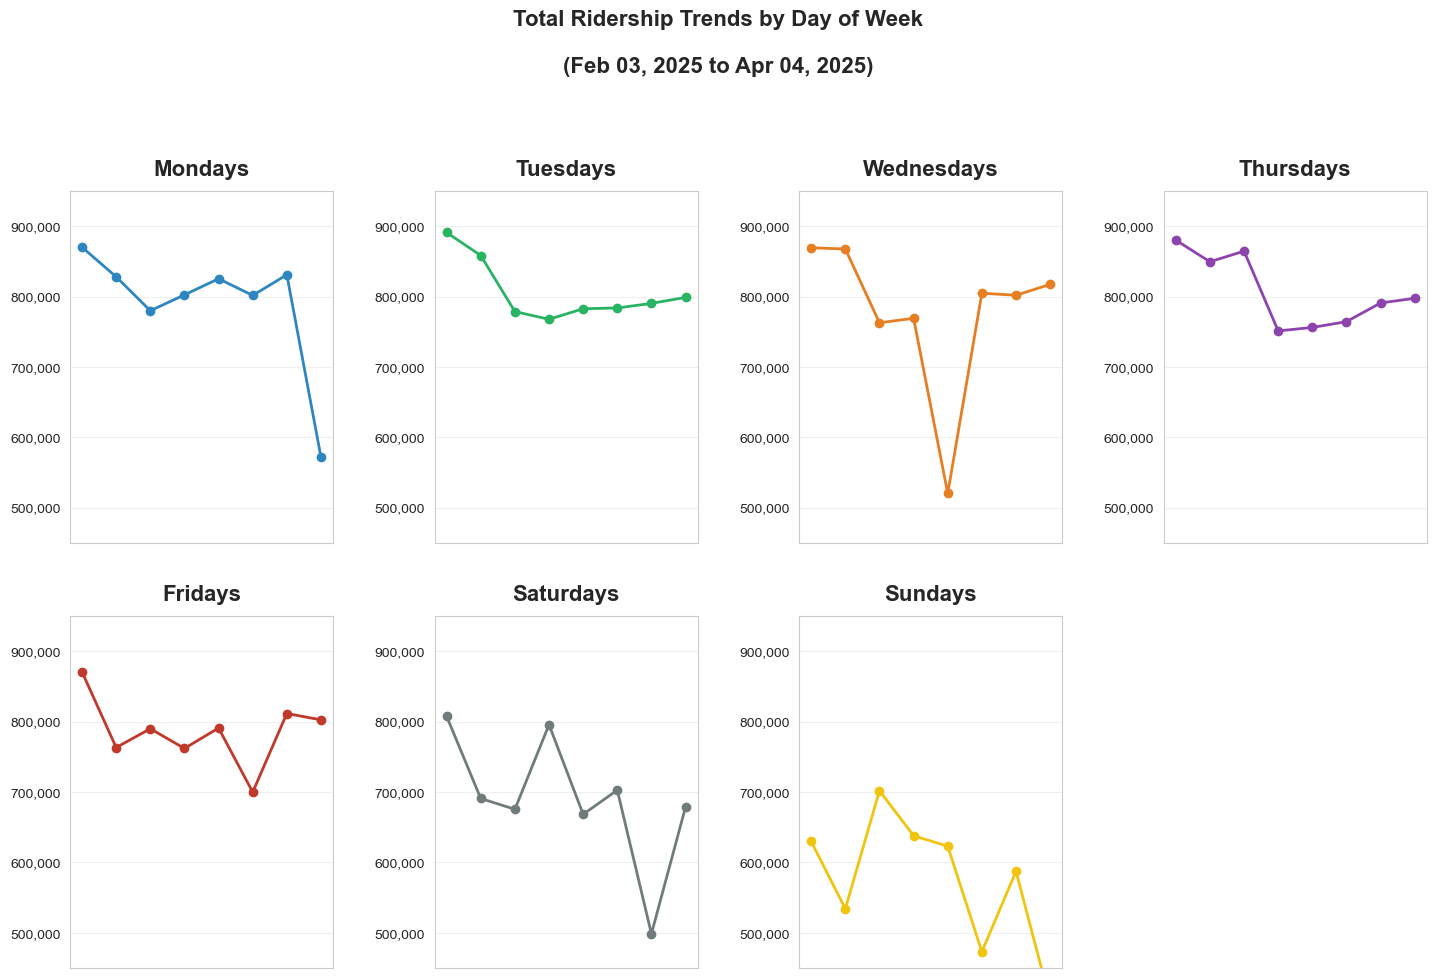

In [287]:
number_of_days = 7 * 8
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = {
    'Monday':    '#2E86C1', # Blue
    'Tuesday':   '#28B463', # Green
    'Wednesday': '#E67E22', # Orange
    'Thursday':  '#8E44AD', # Purple
    'Friday':    '#C0392B', # Red
    'Saturday':  '#707B7C', # Gray
    'Sunday':    '#F1C40F'  # Yellow
}

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
sns.set_style("whitegrid")
axes = axes.flatten()
axes[7].axis('off')

def plot_day_data(ax, day, idx):
    day_data = df[df['Day of Week']==day][['Record Date', 'Total Riders']].tail(int(number_of_days/7))
    
    ax.plot(range(len(day_data)), day_data['Total Riders'], 
            marker='o', markersize=6, linewidth=2, 
            color=colors[day], label=day)
    
    ax.set_title(f'{day}s', fontsize=16, y=1.02, fontweight='bold')
    ax.set_ylabel('', fontsize=11)
    ax.grid(True, axis='both', alpha=0.3)
    ax.set_xticks([])
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.set_ylim(450000, 950000)

for idx, day in enumerate(days):
    plot_day_data(axes[idx], day, idx)

start_date = df[df['Day of Week']=='Monday'].tail(int(number_of_days/7)).reset_index().iloc[0, 1].strftime('%b %d, %Y')
end_date = df['Record Date'].max().strftime('%b %d, %Y')
fig.suptitle(f"Total Ridership Trends by Day of Week\n\n({start_date} to {end_date})", 
             fontsize=16, y=1, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.show()

### **Average Daily Ridership by Day of Week**

In [288]:
# Number of data points available for each day of the week
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

Day of Week
Monday       19
Tuesday      21
Wednesday    18
Thursday     17
Friday       20
Saturday     21
Sunday       16
Name: count, dtype: int64

In [289]:
# Configure parameters to calculate day of week averages
number_of_days = 50
end_date = '2025-03-31'
exclude_dates = ['2025-01-14', '2025-01-15', '2025-01-16', '2025-01-25', '2025-02-26', '2024-11-01']

In [290]:
# Average Daily Ridership by Day of Week: the weekly_average data
rename_map = {
    'Total Smart Cards': 'Smart Cards',
    'Total Tokens': 'Tokens',
    'Total NCMC': 'NCMC',
    'Total QR': 'QR',
    'Day of Week_x': 'Day of Week'
}
payment_columns = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

end_date = pd.to_datetime(end_date)
start_date = max(end_date - pd.Timedelta(days=number_of_days-1), df['Record Date'].min())
mask = (df['Record Date'] >= start_date) & (df['Record Date'] <= end_date)
if exclude_dates:
    exclude_dates = pd.to_datetime(exclude_dates)
    mask &= ~df['Record Date'].isin(exclude_dates)

weekly_average = (df[mask]
                 .rename(columns=rename_map)
                 .groupby('Day of Week')[payment_columns]
                 .mean()
                 .reindex(day_order))
weekly_average = weekly_average.apply(
    lambda x: pd.to_numeric(x.fillna(0), errors='coerce')
    .round()
    .astype('Int64'))
weekly_average['Total Riders'] = weekly_average.sum(axis=1)

neat_date = lambda d: d.strftime('%b %d %Y').lstrip('0').replace(' 0', ' ') 
print("=" * 45)
print("Ridership by Day of Week and Payment Method")
print(f"Averaged between {neat_date(start_date)} and {neat_date(end_date)}")
print("=" * 45)
display(weekly_average)

Ridership by Day of Week and Payment Method
Averaged between Feb 10 2025 and Mar 31 2025


,Smart Cards,NCMC,Tokens,QR,Group Ticket,Total Riders
Day of Week,,,,,,
Monday,393695,17746,197107,168490,200,777238
Tuesday,430600,20619,175825,156349,353,783746
Wednesday,435678,20358,178791,156171,224,791222
Thursday,417604,19505,178828,155584,580,772101
Friday,391203,18504,185541,174112,239,769599
Saturday,276214,10607,196677,188922,498,672918
Sunday,123095,6013,203489,154954,169,487720


### **Average Daily Ridership by Payment Method**

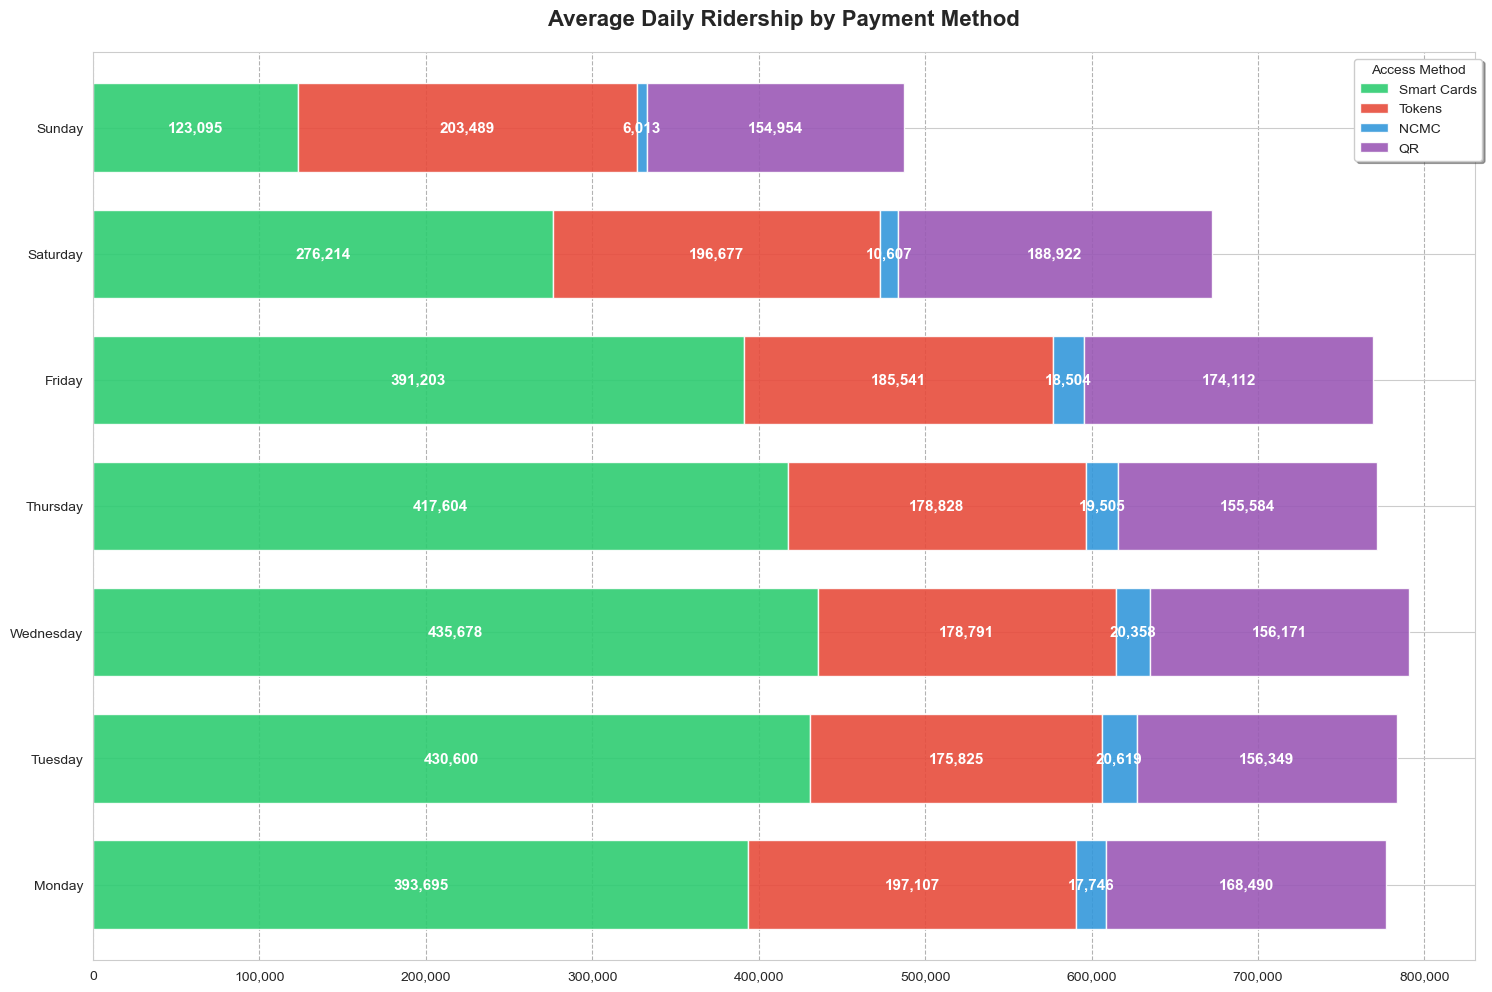

In [291]:

colors = {
    'Smart Cards': '#2ecc71',   # green
    'NCMC': '#3498db',         # blue
    'Tokens': '#e74c3c',      # red
    'QR': '#9b59b6'          # purple
}

ax = weekly_average.loc[:, ['Smart Cards', 'Tokens', 'NCMC', 'QR']].plot(
                             kind='barh', stacked=True, ylabel='',
                             color=[colors[col] for col in ['Smart Cards', 'Tokens', 'NCMC', 'QR']],
                             figsize=(15, 10), width=0.7, rot=0, alpha=0.9)

for c in ax.containers:
    labels = labels = [f'{int(v):,}' if v >= 4000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=11, color='white', fontweight='bold')

plt.title('Average Daily Ridership by Payment Method', 
          fontsize=16, 
          y=1.02, 
          fontweight='bold')
plt.legend(title='Access Method', 
          bbox_to_anchor=(1.01, 1), 
          loc='best',
          frameon=True,
          fancybox=True,
          shadow=True)
plt.grid(axis='x', 
         linestyle='--', 
         alpha=0.6,
         color='gray')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

### **Total Daily Ridership over the Last 7 days**

In [292]:

df_x = df[['Record Date', 'Day of Week', 'Total Riders']].tail(7).copy()
df_x['Day Average'] = df_x['Day of Week'].map(weekly_average['Total Riders'])
df_x['Difference'] = df_x['Total Riders'] - df_x['Day Average']
df_x['Difference'] = df_x['Difference'].apply(lambda x: f"{abs(x)} ⬇︎" if x < 0 else f"⬆︎ {x}")
df_x

,Record Date,Day of Week,Total Riders,Day Average,Difference
125,2025-03-23,Sunday,587362,487720,⬆︎ 99642
126,2025-03-24,Monday,831083,777238,⬆︎ 53845
127,2025-03-26,Wednesday,817346,791222,⬆︎ 26124
128,2025-03-29,Saturday,678724,672918,⬆︎ 5806
129,2025-03-30,Sunday,402795,487720,84925 ⬇︎
130,2025-03-31,Monday,571849,777238,205389 ⬇︎
131,2025-04-04,Friday,802586,769599,⬆︎ 32987


_____
## **Traffic Bands**

In [293]:
# Create df2 with new features for further analysis
df2 = df.copy()

# Create additional features: Day of Week, Traffic Band
df2['Day of Week'] = df2['Record Date'].dt.strftime('%A')
df2['Traffic Band'] = 'Weekday'
df2.loc[(df2['Record Date'].dt.dayofweek >= 4), 'Traffic Band'] = 'Weekend Lite'
df2.loc[(df2['Record Date'].dt.dayofweek == 6), 'Traffic Band'] = 'Weekend'

# Create additional features Commute, Casual and Total
df2['Commute'] = df2['Total Smart Cards'] + df2['Total NCMC']
df2['Casual'] = df2['Total Tokens'] + df2['Total QR'] + df2['Group Ticket']
df2['Total'] = df2['Commute'] + df2['Casual']

# Select features for new dataframe
df2.rename(columns={
    # 'Record Date': 'Date',
    # 'Day of Week':,
    'Total Smart Cards': 'Smart Cards',
    'Total NCMC': 'NCMC',
    # 'Commute':,
    'Total Tokens': 'Tokens',
    'Total QR': 'QR',
    # 'Group Ticket':,
    # 'Casual':,
    # 'Total':,
}, inplace=True)

df2 = df2.assign(**{col: df2[col].astype(int) for col in df2.select_dtypes(include=['float64']).columns})
df2 = df2[['Record Date', 'Day of Week', 'Traffic Band', 
           'Smart Cards', 'NCMC', 'Commute', 
           'Tokens', 'QR', 'Group Ticket', 'Casual', 
           'Total']]
df2.to_csv("NammaMetro_Ridership_Processed.csv", index=False)
display(df2)

,Record Date,Day of Week,Traffic Band,Smart Cards,NCMC,Commute,Tokens,QR,Group Ticket,Casual,Total
0,2024-10-26,Saturday,Weekend Lite,353460,7444,360904,241883,177279,512,419674,780578
1,2024-10-27,Sunday,Weekend,176278,4278,180556,250124,205910,458,456492,637048
2,2024-10-28,Monday,Weekday,452257,11076,463333,208014,177629,160,385803,849136
3,2024-10-29,Tuesday,Weekday,452299,10948,463247,205421,182210,407,388038,851285
4,2024-10-30,Wednesday,Weekday,425759,9975,435734,233366,201583,198,435147,870881
...,...,...,...,...,...,...,...,...,...,...,...
127,2025-03-26,Wednesday,Weekday,449665,20478,470143,191193,155934,76,347203,817346
128,2025-03-29,Saturday,Weekend Lite,270949,10861,281810,209774,186852,288,396914,678724
129,2025-03-30,Sunday,Weekend,96209,4444,100653,172307,129763,72,302142,402795
130,2025-03-31,Monday,Weekday,208196,9122,217318,208738,145793,0,354531,571849


In [294]:
# Weekly Ridership Pattern Table
traffic_bands = {
    'Monday': ('Weekday', '#e6f0ff'),      # Slightly deeper blue-white
    'Tuesday': ('Weekday', '#e6f0ff'),
    'Wednesday': ('Weekday', '#e6f0ff'),
    'Thursday': ('Weekday', '#e6f0ff'),
    'Friday': ('Weekend Lite', '#ffe6e6'),  # Slightly deeper pink-white
    'Saturday': ('Weekend Lite', '#ffe6e6'),
    'Sunday': ('Weekend', '#f0e6ff')        # Slightly deeper purple-white
}
table_lines = []
table_lines.append("<center><table style='color: black'>")
headers = ['Day of Week', 'Traffic Band', 'Commute', 'Casual', 'Total']
table_lines.append("<tr style='background-color: black; color: white'><th>" + "</th><th>".join(headers) + "</th></tr>")
weekly_average['Commute'] = weekly_average['Smart Cards'] + weekly_average['NCMC']
weekly_average['Casual'] = weekly_average['Tokens'] + weekly_average['QR'] + weekly_average['Group Ticket']
weekly_average['Total'] = weekly_average['Commute'] + weekly_average['Casual']

for day in list(traffic_bands):
    band, color = traffic_bands[day]
    table_lines.append(f'<tr style="background-color: {color}">')
    row_data = [
        day,
        band,
        f"{int(weekly_average.loc[day, 'Commute']):,}",
        f"{int(weekly_average.loc[day, 'Casual']):,}",
        f"{int(weekly_average.loc[day, 'Total']):,}"
    ]
    table_lines.append("    <td>" + "</td>    <td>".join(row_data) + "</td>")
    table_lines.append("</tr>")

table_lines.append("</table></center>")
display(Markdown(" ".join(table_lines)))

<center><table style='color: black'> <tr style='background-color: black; color: white'><th>Day of Week</th><th>Traffic Band</th><th>Commute</th><th>Casual</th><th>Total</th></tr> <tr style="background-color: #e6f0ff">     <td>Monday</td>    <td>Weekday</td>    <td>411,441</td>    <td>365,797</td>    <td>777,238</td> </tr> <tr style="background-color: #e6f0ff">     <td>Tuesday</td>    <td>Weekday</td>    <td>451,219</td>    <td>332,527</td>    <td>783,746</td> </tr> <tr style="background-color: #e6f0ff">     <td>Wednesday</td>    <td>Weekday</td>    <td>456,036</td>    <td>335,186</td>    <td>791,222</td> </tr> <tr style="background-color: #e6f0ff">     <td>Thursday</td>    <td>Weekday</td>    <td>437,109</td>    <td>334,992</td>    <td>772,101</td> </tr> <tr style="background-color: #ffe6e6">     <td>Friday</td>    <td>Weekend Lite</td>    <td>409,707</td>    <td>359,892</td>    <td>769,599</td> </tr> <tr style="background-color: #ffe6e6">     <td>Saturday</td>    <td>Weekend Lite</td>    <td>286,821</td>    <td>386,097</td>    <td>672,918</td> </tr> <tr style="background-color: #f0e6ff">     <td>Sunday</td>    <td>Weekend</td>    <td>129,108</td>    <td>358,612</td>    <td>487,720</td> </tr> </table></center>

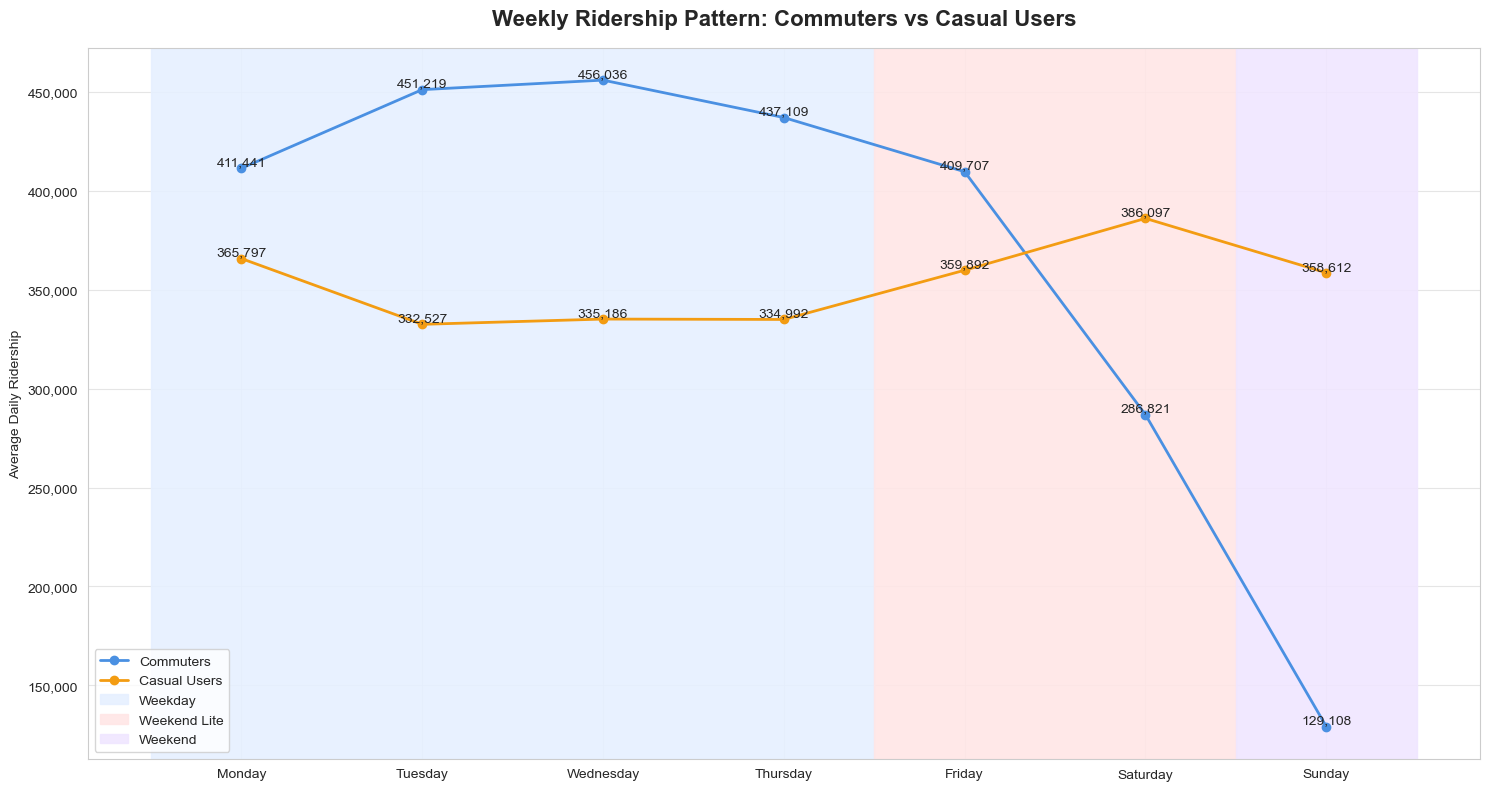

In [295]:
# Weekly Ridership Pattern Line Plot
plt.figure(figsize=(15, 8))
plt.plot(weekly_average.index, weekly_average['Commute'], 
         marker='o', linewidth=2, label='Commuters', 
         color='#4a90e2')
plt.plot(weekly_average.index, weekly_average['Casual'], 
         marker='o', linewidth=2, label='Casual Users', 
         color='#f39c12')

plt.axvspan(-0.5, 3.5, color='#e6f0ff', alpha=0.9, label='Weekday')
plt.axvspan(3.5, 5.5, color='#ffe6e6', alpha=0.9, label='Weekend Lite')
plt.axvspan(5.5, 6.5, color='#f0e6ff', alpha=0.9, label='Weekend')

plt.title('Weekly Ridership Pattern: Commuters vs Casual Users', 
         fontsize=16, y=1.02, fontweight='bold')
plt.xlabel('')
plt.ylabel('Average Daily Ridership')
plt.grid(True, alpha=0.5)
plt.legend(loc="lower left")

for category, col in [('Commuters', 'Commute'), ('Casual Users', 'Casual')]:
    for i, value in enumerate(weekly_average[col]):
        plt.text(i, value, f'{int(value):,}', 
                ha='center', va='bottom', fontsize=10)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

______
## **One Month on NammaMetro**

Remember that NammaMetro fails to report ridership numbers on some days, so the monthly ridership totals calculated from the data is going to be only an approximate. However, we can still identify trends and patterns by analysing data movement on a granular level.

Here are the official monthly ridership stats as reported by BMRCL:

<small>

**Month**      | **Ridership**
---------------|---------------
2024 July      | 23,633,166
2024 August    | Unavailable
2024 September | 23,072,685
2024 October   | Unavailable
2024 November  | 23,613,895
2024 December  | 24,982,906
2025 January   | 24,914,736
2025 February  | 20,990,894

</small>

Let us try to construct the monthly ridership numbers from the available data. 

In [296]:
def trimmed_df(df, number_of_days=None, end_date=None, exclude_dates=None, weekly_average=None):
    """
    Return a trimmed DataFrame based on date parameters.
    If weekly_average is provided, uses it to impute missing values.
    Always includes is_imputed column (False for original data).
    """
    # Create working copy
    result = df.copy()
    
    # Handle date parameters
    end_date = pd.to_datetime(end_date) if end_date else result['Record Date'].max()
    if number_of_days:
        start_date = end_date - pd.Timedelta(days=number_of_days-1)
        result = result[result['Record Date'] >= start_date]
    result = result[result['Record Date'] <= end_date]
    
    # Handle exclusions
    if exclude_dates:
        exclude_dates = pd.to_datetime(exclude_dates)
        for date in exclude_dates:
            result = result[result['Record Date'] != date]    
    
    if weekly_average is not None:
        # Create complete date range
        date_range = pd.date_range(start=result['Record Date'].min(), 
                                 end=result['Record Date'].max(), 
                                 freq='D')
        date_range = date_range[~date_range.isin(exclude_dates)] if exclude_dates else date_range
        
        # Create base DataFrame with all dates
        complete = pd.DataFrame(index=date_range)
        complete.index.name = 'Record Date'
        complete = complete.reset_index()
        complete['Day of Week'] = complete['Record Date'].dt.strftime('%A')
        
        # Mark original dates before merge for accurate imputation flag
        result['_original'] = True
        
        # Merge with actual data
        result = complete.merge(result, how='left', on=['Record Date', 'Day of Week'])
        
        # Set imputation flag before filling values
        result['is_imputed'] = result['_original'].isna()
        result = result.drop('_original', axis=1)
        
        # Impute missing values
        numeric_cols = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket', 
                       'Commute', 'Casual', 'Total']
        for col in numeric_cols:
            if col in weekly_average.columns:
                mask = result[col].isna()
                result.loc[mask, col] = result.loc[mask, 'Day of Week'].map(weekly_average[col])
                result[col] = result[col].round().astype('Int64')
        
        # Ensure Traffic Band is set
        result['Traffic Band'] = 'Weekday'
        result.loc[result['Record Date'].dt.dayofweek >= 4, 'Traffic Band'] = 'Weekend Lite'
        result.loc[result['Record Date'].dt.dayofweek == 6, 'Traffic Band'] = 'Weekend'
    else:
        # If no imputation, all rows are original data
        result['is_imputed'] = False
    
    return result.sort_values('Record Date').reset_index(drop=True)

In [297]:
def estimate_monthly_ridership(df, start_date='2024-11-01'):
    """
    Calculate monthly ridership with estimates for missing dates based on
    same day-of-week averages within the same month.
    """
    df = df[df['Record Date'] >= start_date].copy()
    min_date = df['Record Date'].min()
    max_date = df['Record Date'].max()
    monthly_stats = []
    months = pd.period_range(start=min_date, end=max_date, freq='M')[:-1]

    for month in months:
        month_data = df[(df['Record Date'] >= month.start_time) 
                      & (df['Record Date'] <= month.end_time)]

        # Create complete month with imputed values
        dow_averages = month_data.groupby(month_data['Record Date'].dt.day_name()).mean(numeric_only=True)
        complete_month = trimmed_df(
            month_data, 
            end_date=month.end_time,
            weekly_average=dow_averages
        )

        # Calculate statistics for this month
        total_rides = complete_month['Total'].sum()
        avg_daily = complete_month['Total'].mean()
        total_days = len(complete_month)
        estimated_days = complete_month['is_imputed'].sum()

        monthly_stats.append({
            'Year-Month': month,
            'Monthly Total (millions)': round(total_rides / 1_000_000, 1),
            'Daily Average (thousands)': round(avg_daily / 1_000, 1)
        })

    return pd.DataFrame(monthly_stats)

In [298]:

print("="*35)
print("Total Rides Served per Month ⁺")
print("="*35)

month_df = estimate_monthly_ridership(df2, start_date='2024-11-1')

display(month_df)
print(f"⁺ Estimate includes data for missing dates based on same day-of-week averages within each month.")
print(f"  Data as of {df2['Record Date'].max().strftime('%Y-%m-%d')}.")

Total Rides Served per Month ⁺


,Year-Month,Monthly Total (millions),Daily Average (thousands)
0,2024-11,23.7,788.8
1,2024-12,24.7,795.7
2,2025-01,24.2,807.4
3,2025-02,20.4,755.8
4,2025-03,22.2,716.6


⁺ Estimate includes data for missing dates based on same day-of-week averages within each month.
  Data as of 2025-04-04.


### **The Spread of Data**

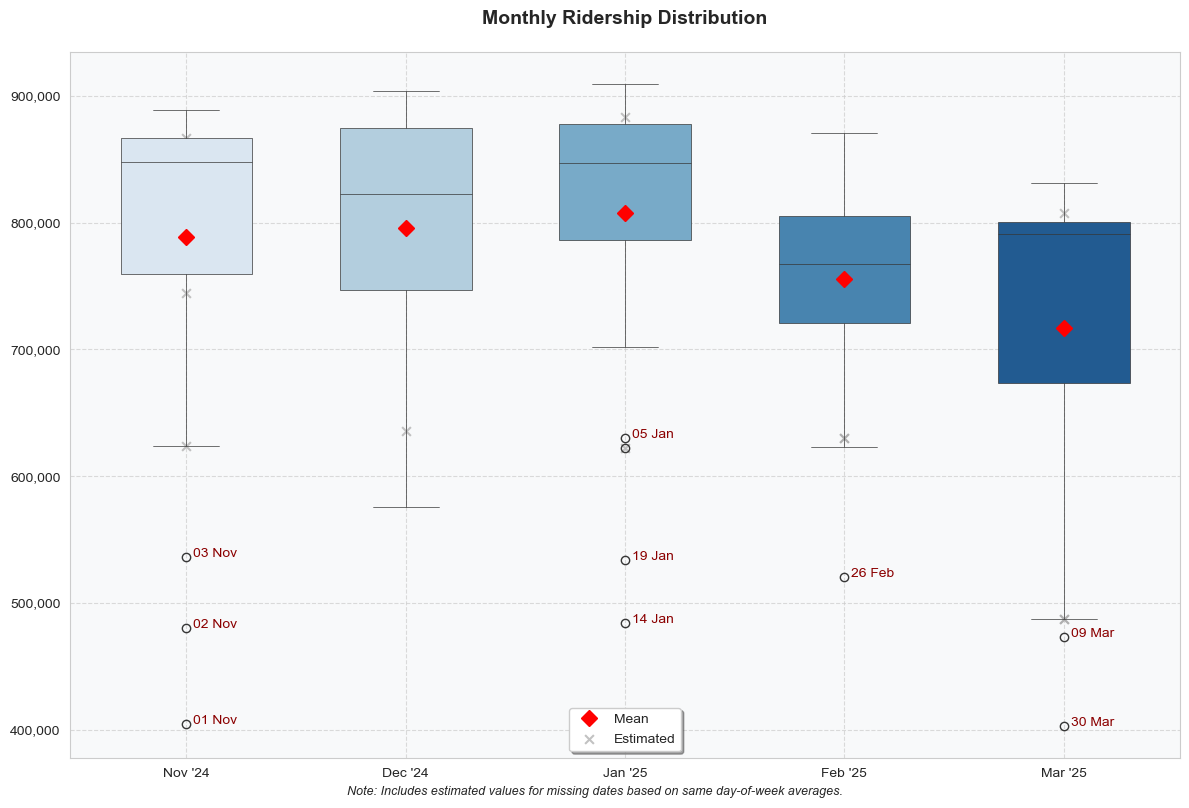

In [299]:
def create_monthly_boxplot(df, start_date='2024-11-01', include_estimates=True):
    """
    Create a boxplot showing monthly ridership distribution with outliers labeled.
    
    Parameters:
    -----------
    df : DataFrame
        The ridership dataframe
    start_date : str
        Start date for analysis in 'YYYY-MM-DD' format
    include_estimates : bool
        Whether to include estimated values for missing dates
    """

    df = df[df['Record Date'] >= start_date].copy()
    latest_complete_month = df['Record Date'].max().to_period('M') - 1
    months = pd.period_range(start=df['Record Date'].min().to_period('M'), 
                           end=latest_complete_month, 
                           freq='M')
    
    if include_estimates:
        complete_data = pd.DataFrame()
        for month in months:
            month_data = df[(df['Record Date'] >= month.start_time) & 
                           (df['Record Date'] <= month.end_time)]
            
            dow_averages = month_data.groupby(month_data['Record Date'].dt.day_name()).mean(numeric_only=True)
            complete_month = trimmed_df(month_data, end_date=month.end_time, weekly_average=dow_averages)
            complete_data = pd.concat([complete_data, complete_month])
        
        months_df = complete_data.reset_index(drop=True)
    else:
        months_df = df[df['Record Date'] <= latest_complete_month.end_time]
    
    months_df['Month'] = months_df['Record Date'].dt.to_period('M')

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))    
    ax = sns.boxplot(data=months_df,
                x='Month',
                y='Total',
                hue='Month',
                palette='Blues',
                width=0.6, 
                linewidth=0.5,
                legend=False)

    plt.title('Monthly Ridership Distribution', pad=20, fontsize=14, fontweight='bold')    
    plt.xlabel('', fontsize=12)
    plt.ylabel('', fontsize=12)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels([month.strftime('%b \'%y') for month in months])

    means = months_df.groupby('Month')['Total'].mean()
    plt.plot(range(len(means)), means, 'D', color='red', markersize=8, label='Mean')
    
    if include_estimates:
        for month_idx, month in enumerate(months):
            est_points = months_df[(months_df['Month'] == month) & 
                                 (months_df['is_imputed'])]
            if not est_points.empty:
                plt.scatter([month_idx] * len(est_points), est_points['Total'], 
                           marker='x', color='darkgray', alpha=0.7, s=40,
                           label='Estimated' if month_idx == 0 else "")

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('#f8f9fa')
    
    for i, month in enumerate(months):
        month_data = months_df[months_df['Month'] == month]
        
        Q1, Q3 = month_data['Total'].quantile(0.25), month_data['Total'].quantile(0.75)
        IQR = Q3 - Q1
        
        outliers = month_data[(month_data['Total'] < (Q1 - 1.5 * IQR)) | 
                             (month_data['Total'] > (Q3 + 1.5 * IQR))]
        
        if include_estimates:
            outliers = outliers[~outliers['is_imputed']]
        
        for _, row in outliers.iterrows():
            plt.annotate(row['Record Date'].strftime('%d %b'), 
                        xy=(i, row['Total']), 
                        xytext=(5, 0),
                        textcoords='offset points',
                        fontsize=10,
                        color='darkred')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), 
              loc='lower center', frameon=True, fancybox=True, shadow=True)
    
    if include_estimates:
        est_text = "Note: Includes estimated values for missing dates based on same day-of-week averages."
        plt.figtext(0.5, 0.00, est_text, ha='center', fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    return months_df

boxplot_data = create_monthly_boxplot(df2)

### **Ebb and Flow of Daily Passenger Traffic**

In [300]:
def plot_ridership_trend(df, traffic_band='all', user_type='all', base_value=0, ax=None):
    """
    Plot ridership trend with optional filtering by traffic band and user type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame in df2 format with Record Date, Traffic Band, Commute, Casual columns
    traffic_band : str, optional
        Filter for traffic type: 'all', 'Weekday', 'Weekend Lite', 'Weekend' (default: 'all')
    user_type : str, optional
        Filter for user type: 'all', 'Commute', 'Casual' (default: 'all')
    base_value : int, optional
        Base value for the y-axis (default: 0)
    ax : matplotlib.axes._axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.
    """

    data = df.copy()
    
    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    else:
        fig = ax.figure  # Get the figure from the provided axes

    # Apply necessary filters
    if traffic_band != 'all':
        data = data[data['Traffic Band'] == traffic_band]
    if user_type != 'all':
        data['Total'] = data[user_type]
    if len(data) == 0:
        print(f"No data available after applying filters")
        return None, None
    data = data.sort_values('Record Date').reset_index(drop=True)
    
    # Fill between for all data
    if user_type == 'Commute':
        line_color = '#f39c12'  # orange for Commuters
    elif user_type == 'Casual':
        line_color = '#4a90e2'  # blue for Casual Users
    else:
        line_color = '#8B2183'  # purple for Total/default
    ax.fill_between(data['Record Date'], 
                     data['Total'],
                     y2=base_value,
                     alpha=0.2,
                     color=line_color,
                     linewidth=2 + int(line_color != '#8B2183'))

    # Find gaps in dates
    date_series = pd.Series(data['Record Date'], )
    date_gaps = date_series.diff() > pd.Timedelta(days=1)
    gap_indices = date_gaps[date_gaps].index.tolist()
    
    if gap_indices:
        # Plot first segment
        ax.plot(data.loc[:gap_indices[0]-1, 'Record Date'],
                data.loc[:gap_indices[0]-1, 'Total'],
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                label='Daily Ridership (Actual Data)')
        
        # Add dummy plot for legend
        ax.plot([], [], 
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                linestyle='--',
                label='Daily Ridership (Gaps in Data)')
        
        # Plot segments and gaps
        for i in range(len(gap_indices)):
            start_idx = gap_indices[i]
            end_idx = gap_indices[i+1]-1 if i < len(gap_indices)-1 else len(data)-1
            
            # Plot segment
            ax.plot(data.loc[start_idx:end_idx, 'Record Date'],
                    data.loc[start_idx:end_idx, 'Total'],
                    color=line_color,
                    linewidth=2 + int(line_color != '#8B2183'))
            
            # Plot gap
            if i < len(gap_indices):
                ax.plot([data.loc[start_idx-1, 'Record Date'], 
                         data.loc[start_idx, 'Record Date']],
                        [data.loc[start_idx-1, 'Total'], 
                         data.loc[start_idx, 'Total']],
                        color=line_color,
                        linewidth=2 + int(line_color != '#8B2183'),
                        linestyle='--')
    else:
        # No gaps, plot as single line
        ax.plot(data['Record Date'], 
                data['Total'],
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                label='Daily Ridership')

    # Add regression line for non-zero values
    valid_data = data[data['Total'] > 0]
    if len(valid_data) > 1:  # Need at least 2 points for regression
        date_nums = mdates.date2num(valid_data['Record Date'])
        slope, intercept, r_value, p_value, std_err = linregress(date_nums, valid_data['Total'].values)
        line = slope * date_nums + intercept
        avg_riders = valid_data['Total'].mean()
        ax.axhline(y=avg_riders, color='#27AE60', linestyle='--', alpha=0.8,
                    label=f'Average ({int(avg_riders):,} riders)')
        ax.plot(valid_data['Record Date'], line, '--', 
                color='#D4268E',
                alpha=0.8, 
                label=f'Trend (R² = {r_value**2:.3f})')
        
        # Add confidence intervals
        conf = 0.95
        n = len(date_nums)
        mean_x = np.mean(date_nums)
        se = std_err * np.sqrt(1/n + (date_nums - mean_x)**2 / np.sum((date_nums - mean_x)**2))
        ci = t.ppf((1 + conf)/2, n - 2) * se
        ax.fill_between(valid_data['Record Date'], 
                         line - ci, line + ci, 
                         color='r', alpha=0.1)

    # Create title
    title_parts = ["Total Daily Ridership"]
    start_date = data['Record Date'].min()
    end_date = data['Record Date'].max()
    if traffic_band != 'all' or user_type != 'all':
        title_parts.append("–")
    if traffic_band != 'all':
        title_parts.append(f"{traffic_band}")
    if user_type != 'all':
        title_parts.append(f"{user_type}")
    title_parts.append(f"\n\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})")
    title = " ".join(title_parts)

    ax.set_title(title, fontsize=16, y=1.02, fontweight='bold')
    ax.set_ylabel('Daily Ridership', fontsize=12)
    ax.grid(True, axis='both', alpha=0.3)
    ax.set_ylim(bottom=base_value, top=1000000 if user_type=='all' else 700000)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Format x-axis dates
    ax.set_xticks(data['Record Date'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
    plt.tight_layout()

    if ax is None:
        plt.show()
        return fig, ax  # Return fig and ax when creating a new plot
    else:
        return None, None  # Return None, None when using an existing ax

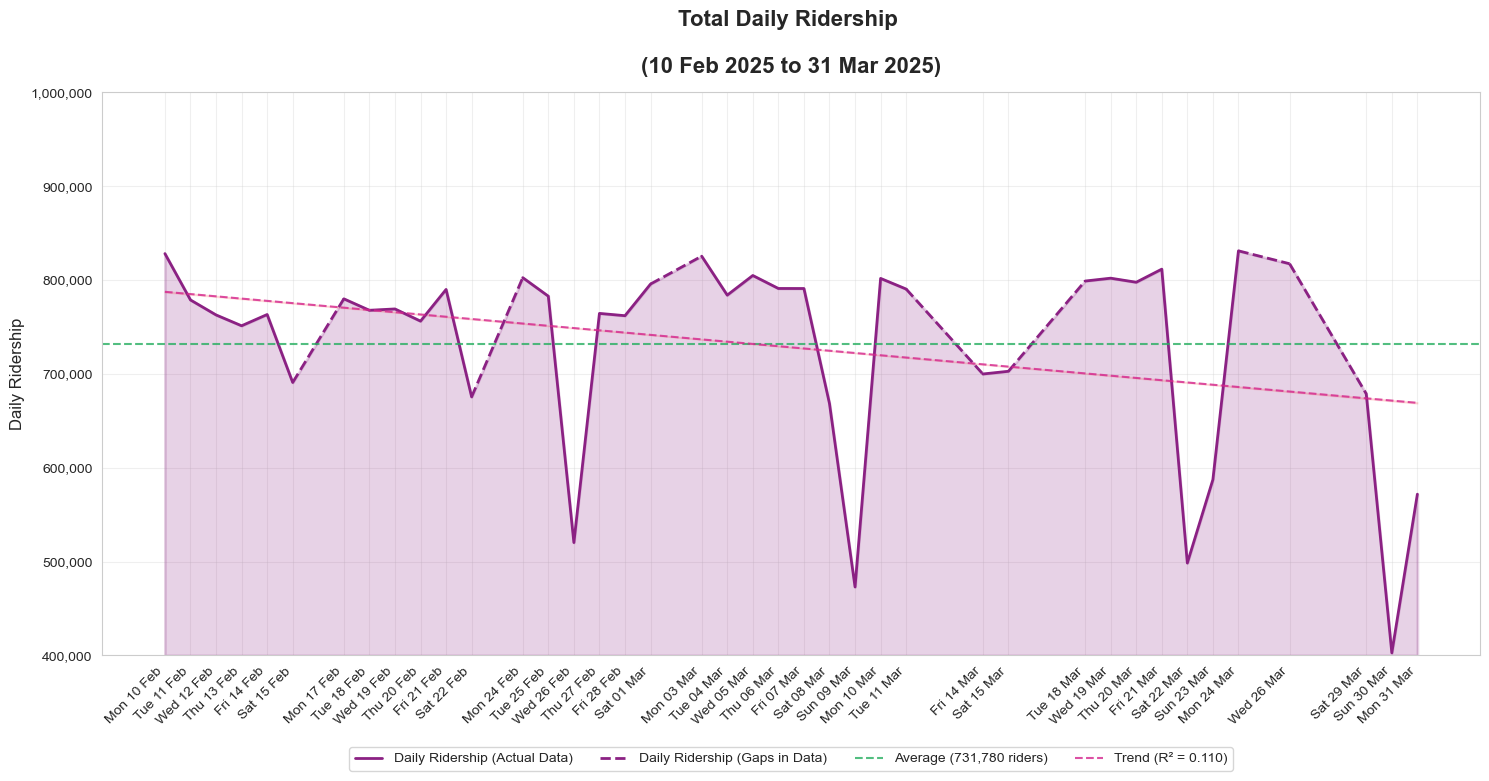

In [301]:
# yesterday = (pd.Timestamp.today() - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
plot_this_df = trimmed_df(df2, number_of_days=50, end_date='2025-03-31')
ax = plot_ridership_trend(plot_this_df, base_value=400000)

<small>

| R² Range | Interpretation | Use Case |
|----------|---------------|-----------|
| > 0.75 | Very Strong | Highly reliable for forecasting |
| 0.50 - 0.75 | Strong | Good for general predictions |
| 0.25 - 0.50 | Moderate | Use with caution |
| 0.10 - 0.25 | Weak | Not suitable for predictions |
| ≤ 0.10 | Very Weak | Indicates random behaviour |

</small>

### **A Wave Rides NammaMetro**

In [302]:
def plot_passes_trend(df, 
                      number_of_days=None, 
                      end_date=None, 
                      pass_types=['One Day Pass', 'Three Day Pass', 'Five Day Pass'],
                      ax=None,
                      significant_dates=False):
    passes_df = df.copy()
    passes_df['Record Date'] = pd.to_datetime(passes_df['Record Date'], dayfirst=True)
    number_of_days = number_of_days if number_of_days else len(passes_df) 
    end_date = pd.to_datetime(end_date) \
        if pd.to_datetime(end_date) <= passes_df['Record Date'].max() \
            else passes_df['Record Date'].max() \
                if end_date else passes_df['Record Date'].max()
    start_date = end_date - pd.Timedelta(days=number_of_days-1)
    passes_df = passes_df[(passes_df['Record Date'] >= start_date) & (passes_df['Record Date'] <= end_date)]
    passes_df['Traffic Band'] = 'Weekday'
    passes_df.loc[(passes_df['Record Date'].dt.dayofweek >= 4), 'Traffic Band'] = 'Weekend Lite'
    passes_df.loc[(passes_df['Record Date'].dt.dayofweek == 6), 'Traffic Band'] = 'Weekend'

    # Define pass types and their corresponding colors
    colors = ['#8b2183', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    traffic_bands = {
        'Monday': ('Weekday', '#e6f0ff'),
        'Tuesday': ('Weekday', '#e6f0ff'),
        'Wednesday': ('Weekday', '#e6f0ff'),
        'Thursday': ('Weekday', '#e6f0ff'),
        'Friday': ('Weekend Lite', '#ffe6e6'),
        'Saturday': ('Weekend Lite', '#ffe6e6'),
        'Sunday': ('Weekend', '#f0e6ff')}

    # Shade traffic bands
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    else:
        fig = ax.figure
    labeled_bands = set()
    current_date = start_date
    while current_date <= end_date:
        day_name = current_date.strftime('%A')
        band, color = traffic_bands[day_name]        
        start_num = mdates.date2num(current_date)
        end_num = mdates.date2num(current_date + pd.Timedelta(days=1))
        if band not in labeled_bands:
            ax.axvspan(start_num, end_num, facecolor=color, alpha=0.7, label=band)
            labeled_bands.add(band)
        else:
            ax.axvspan(start_num, end_num, facecolor=color, alpha=0.7)
        current_date += pd.Timedelta(days=1)

    # Plot each pass type
    for i, pass_type in enumerate(pass_types):
        # Add dummy plots for legend
        ax.plot([], [], color=colors[i], linewidth=2, label=f'{pass_type} (Solid)')
        ax.plot([], [], color=colors[i], linewidth=2, linestyle='--', label=f'{pass_type} (Gaps)')

        # Calculate date differences
        passes_df['date_diff'] = passes_df['Record Date'].diff().dt.days

        # Start a new segment when diff > 1
        passes_df['segment'] = (passes_df['date_diff'] > 1).cumsum()

        # Plot each segment
        for segment in passes_df['segment'].unique():
            segment_data = passes_df[passes_df['segment'] == segment]
            
            # Plot solid line for the segment
            if len(segment_data) > 0:
                ax.plot(segment_data['Record Date'], 
                       segment_data[pass_type],
                       color=colors[i], 
                       linewidth=2)

            # If there's a next segment, plot dashed line between segments
            next_segment = segment + 1
            if next_segment in passes_df['segment'].unique():
                next_segment_data = passes_df[passes_df['segment'] == next_segment]
                if len(next_segment_data) > 0:
                    # Plot dashed line between segments
                    ax.plot([segment_data['Record Date'].iloc[-1], 
                            next_segment_data['Record Date'].iloc[0]],
                           [segment_data[pass_type].iloc[-1], 
                            next_segment_data[pass_type].iloc[0]],
                           color=colors[i], 
                           linewidth=2, 
                           linestyle='--')

    # Add significant dates
    if significant_dates:
        try:
            significant_dates_df = pd.read_csv('significant_dates.csv')
            significant_dates_df['Date'] = pd.to_datetime(significant_dates_df['Date'], format='%Y-%m-%d')
            
            # Get y-axis limits for text positioning
            y_min, y_max = ax.get_ylim()
            text_positions = np.linspace(y_max*0.3, y_max*0.7, len(significant_dates_df))
            
            for idx, (_, row) in enumerate(significant_dates_df.iterrows()):
                date = row['Date']
                event = row['Event']
                if start_date <= date <= end_date:
                    date_num = mdates.date2num(date)
                    ax.axvline(date_num, color='#FF6B6B', linestyle='--', linewidth=1, alpha=0.7)
                    
                    # Position text at different heights to avoid overlap
                    ax.text(date_num, text_positions[idx], event, 
                           rotation=90, 
                           verticalalignment='bottom',
                           horizontalalignment='right',
                           color='#FF6B6B',
                           fontsize=12,
                           fontweight='bold',
                           alpha=0.8,
                           bbox=dict(facecolor='white', 
                                   edgecolor='none',
                                   alpha=0.7,
                                   pad=2))
        except FileNotFoundError:
            print("significant_dates.csv not found. Skipping significant dates annotation.")

    # Format the plot
    metrics_text = 'Multiple Metrics' if len(pass_types) > 2 else ' vs '.join(pass_types)
    title = f"{metrics_text} Usage Trend\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})"
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    x_min = passes_df['Record Date'].min() - pd.Timedelta(days=0.5)
    x_max = passes_df['Record Date'].max() + pd.Timedelta(days=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(passes_df['Record Date'])
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('', fontsize=12)
    plt.ylabel('', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Remove duplicate band labels
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), fontsize=10)
    plt.tight_layout()
    if ax is None:
        plt.show()
        return fig, ax
    else:
        return None, None

_____
## **Phenomena Inspector**

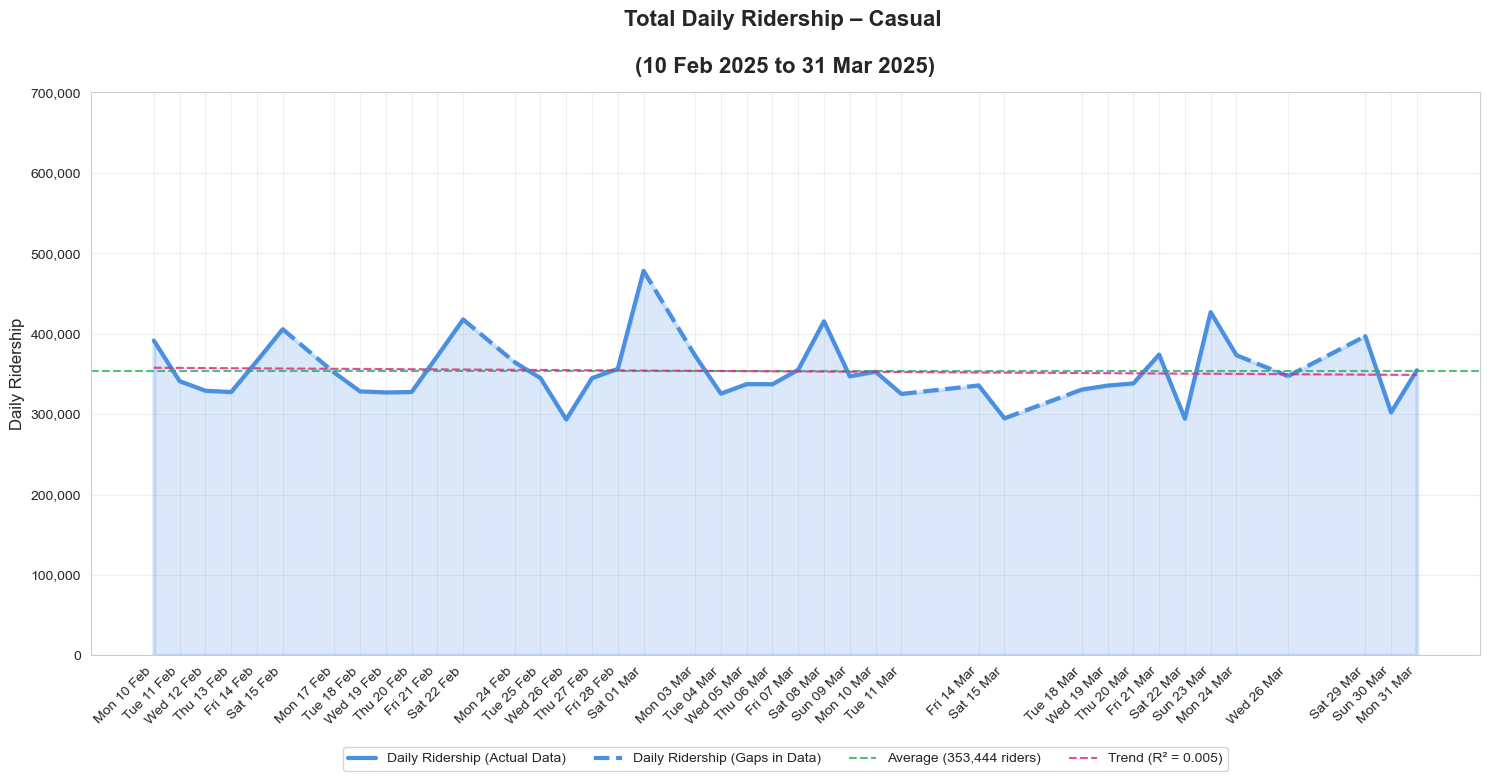

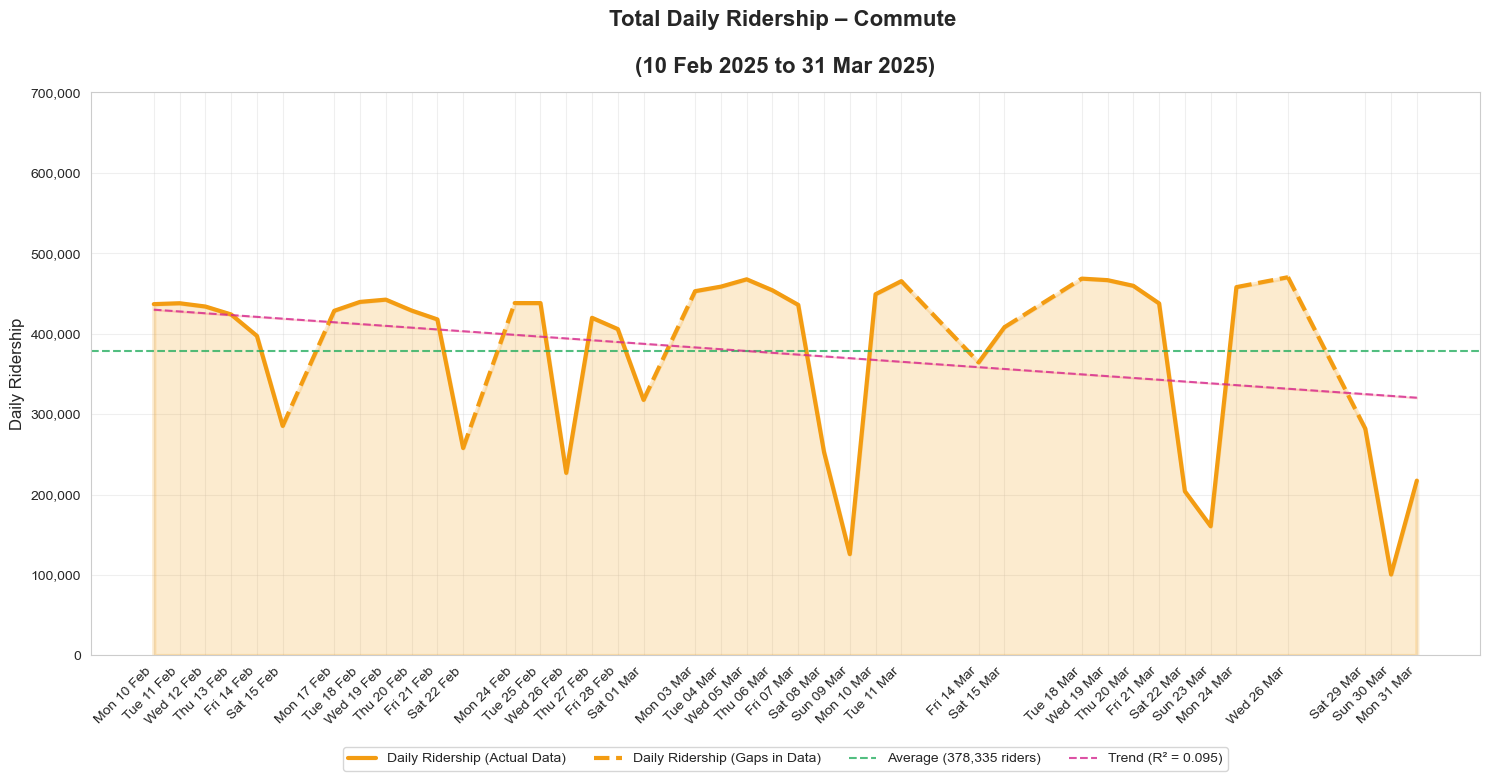

In [303]:
plot_this_df = trimmed_df(df2, number_of_days=number_of_days, end_date=end_date)
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Casual')
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Commute')

### **Ridership Towers – Users and Payments**

In [304]:
def plot_stacked_ridership(df, stack_by='user', traffic_band='all', base_value=0, ax=None):
    """
    Plot stacked histogram of ridership data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame in df2 format with Record Date, Traffic Band, Commute, Casual columns
    stack_by : str, optional
        What to stack by: 'user' (Commute/Casual) or 'payment' (Smart Cards/Tokens/etc)
        (default: 'user')
    traffic_band : str, optional
        Filter for traffic type: 'all', 'Weekday', 'Weekend Lite', 'Weekend' (default: 'all')
    base_value : int, optional
        Base value for the y-axis (default: 0)
    ax : matplotlib.axes._axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.
    """
    data = df.copy()

    if traffic_band != 'all':
        data = data[data['Traffic Band'] == traffic_band]    
    if len(data) == 0:
        print(f"No data available after applying filters")
        return None, None
    data = data.sort_values('Record Date').reset_index(drop=True)
    start_date = data['Record Date'].min()
    end_date = data['Record Date'].max()
    number_of_days = len(data)

    if stack_by == 'user':
        value_vars = ['Casual', 'Commute']
        palette = ['#8fc0ee', '#ffd690']
        title_prefix = 'User Type'
    elif stack_by == 'payment':
        value_vars = ['Group Ticket', 'QR', 'Tokens', 'NCMC', 'Smart Cards']
        palette = 'rocket_r'
        title_prefix = 'Payment Method'
    else:
        raise ValueError("stack_by must be either 'user' or 'payment'")

    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,10))
    else:
        fig = ax.figure  # Get the figure from the provided axes

    melted_data = data.melt(
        id_vars=['Record Date', 'is_imputed'],
        value_vars=value_vars,
        var_name=title_prefix,
        value_name='Count')

    sns.histplot(data=melted_data, 
                x='Record Date',
                weights='Count',
                bins=number_of_days,
                hue=title_prefix,
                multiple='stack',
                element='step',
                palette=palette,
                legend=True,
                common_norm=True,
                stat='count',
                linewidth=0.8,
                alpha=0.7,
                discrete=True,
                kde=False,
                edgecolor='black',
                ax=ax)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    ax.grid(axis='x', alpha=0.5)
    ax.set_title(f"Total Daily Ridership by {title_prefix}\n\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})", 
              fontsize=16, y=1.02, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    ax.set_xticks(data['Record Date'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    date_series = pd.Series(data['Record Date'])
    date_gaps = date_series.diff() > pd.Timedelta(days=1)
    gap_indices = date_gaps[date_gaps].index.tolist()    
    if len(gap_indices) > 0:
        marker_y = data['Total'].max() * 1.02
        for idx in gap_indices:
            ax.axvline(x=data.loc[idx-1, 'Record Date'], color='gray', 
                       linestyle='--', alpha=0.5, linewidth=1)

    imputed_dates = data[data['is_imputed']]['Record Date']
    if len(imputed_dates) > 0:
        marker_y = data['Total'].max() * 1.02
        ax.plot(imputed_dates, [marker_y] * len(imputed_dates), 
                'k*', markersize=8, alpha=0.7, label='Imputed Data')
        ax.text(0.02, 0.98, '* Imputed from weekly averages', 
                transform=ax.transAxes, 
                fontsize=10, 
                verticalalignment='top')

    ax.set_ylim(bottom=base_value)
    plt.tight_layout()

    if ax is None:
        plt.show()
        return fig, ax  # Return fig and ax when creating a new plot
    else:
        return None, None  # Return None, None when using an existing ax

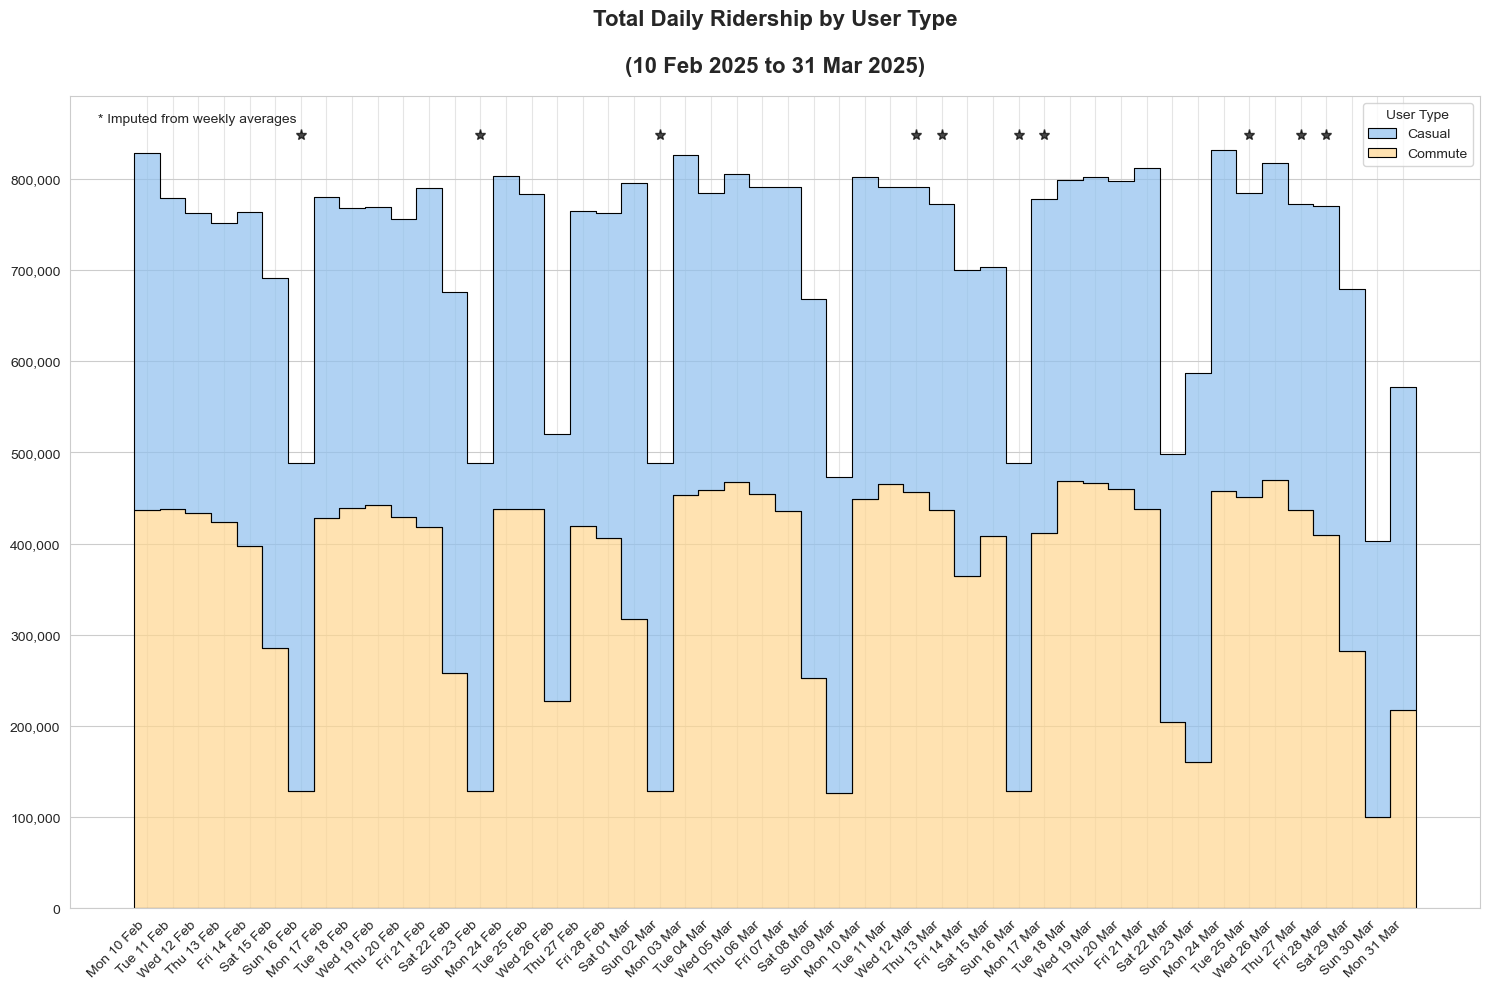

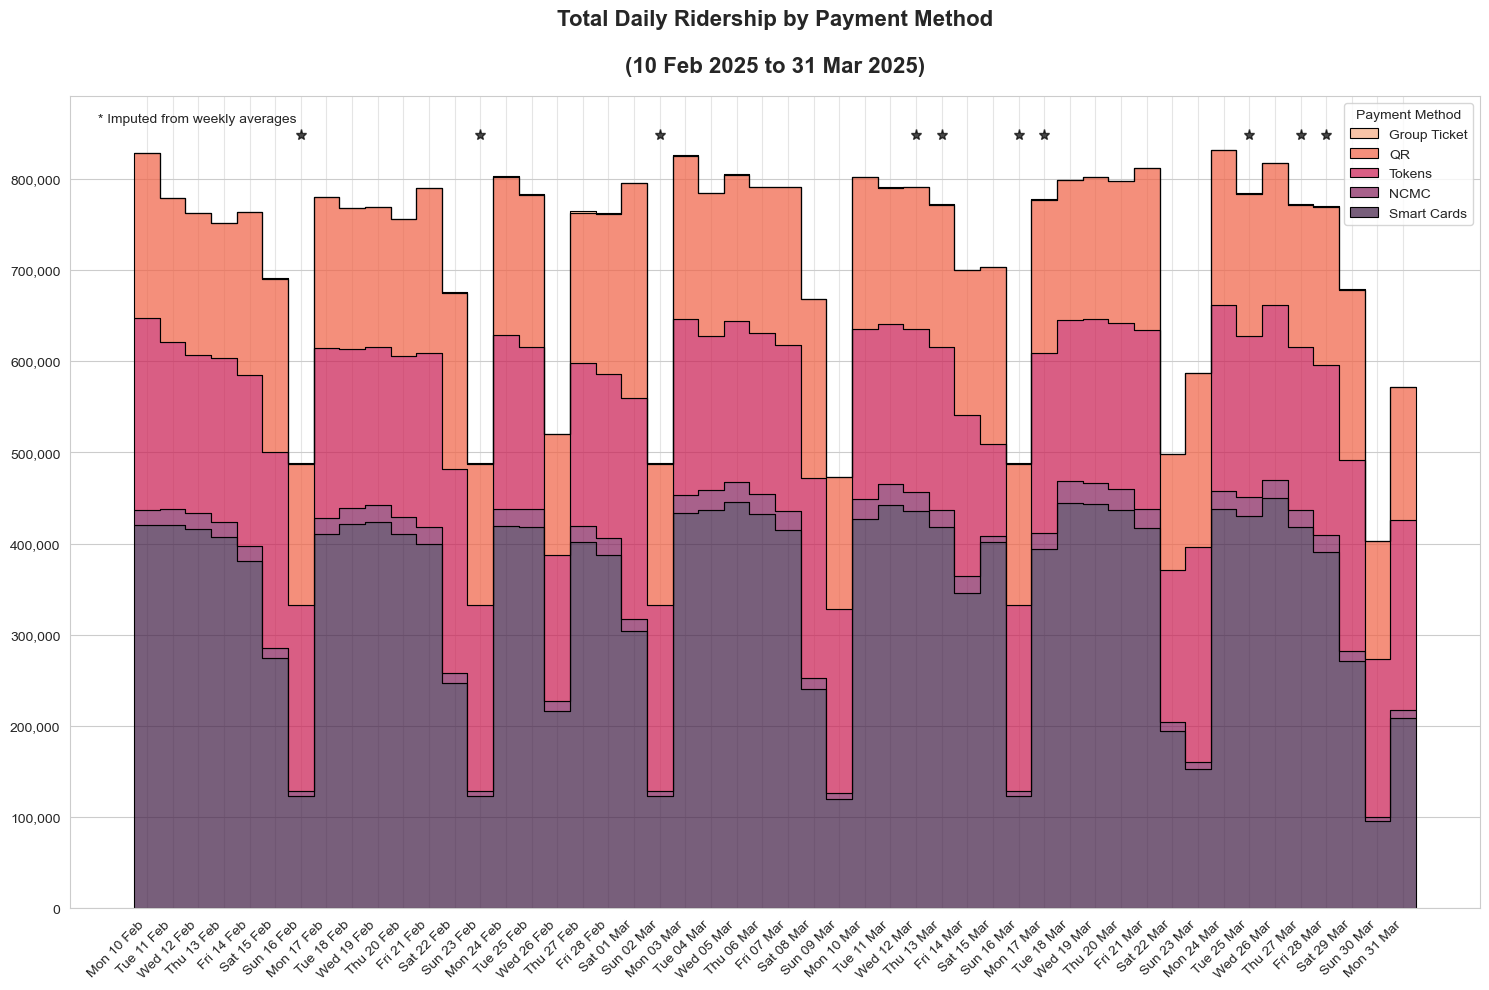

In [305]:
plot_this_df = trimmed_df(df2, number_of_days=number_of_days, end_date=end_date, weekly_average=weekly_average)

ax = plot_stacked_ridership(plot_this_df, stack_by='user', traffic_band='all')
ax = plot_stacked_ridership(plot_this_df, stack_by='payment', traffic_band='all')

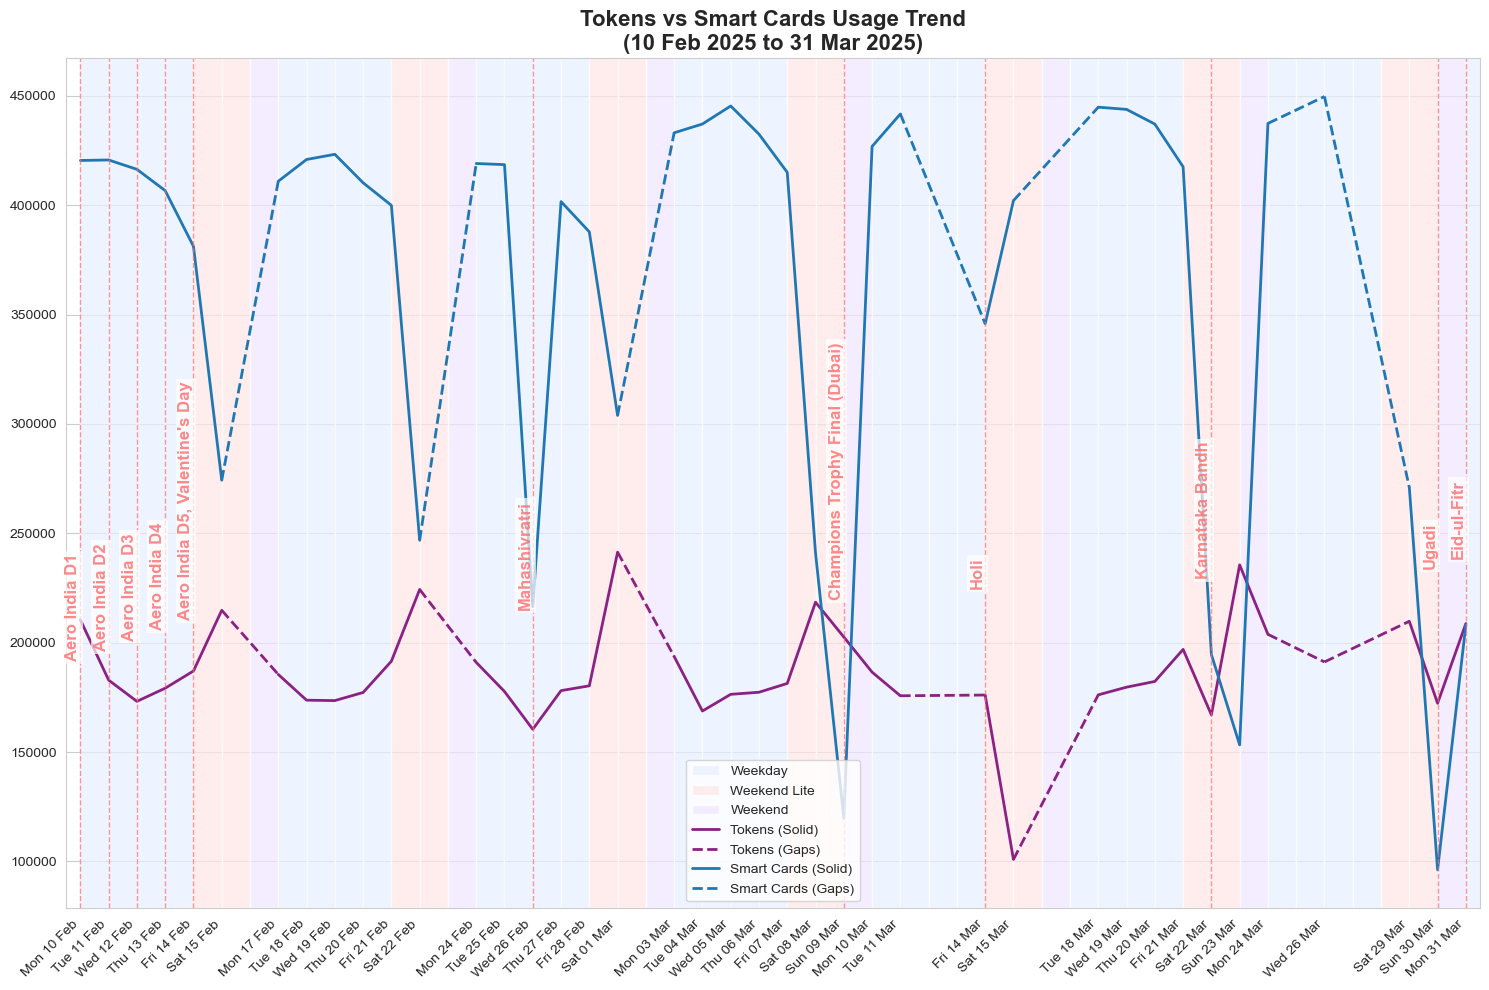

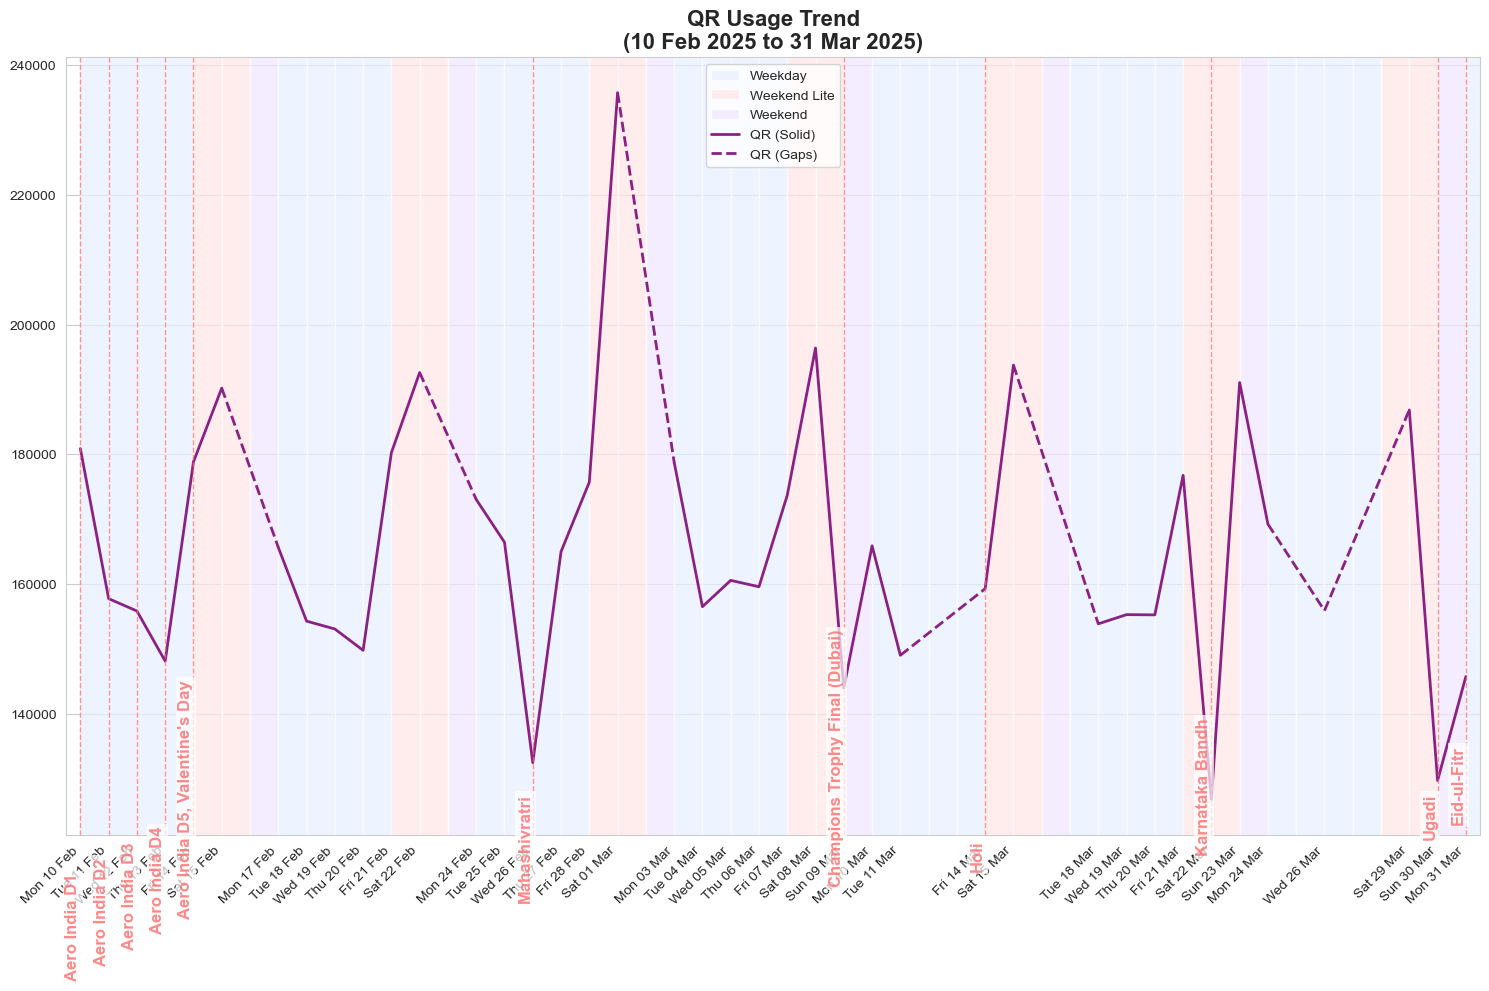

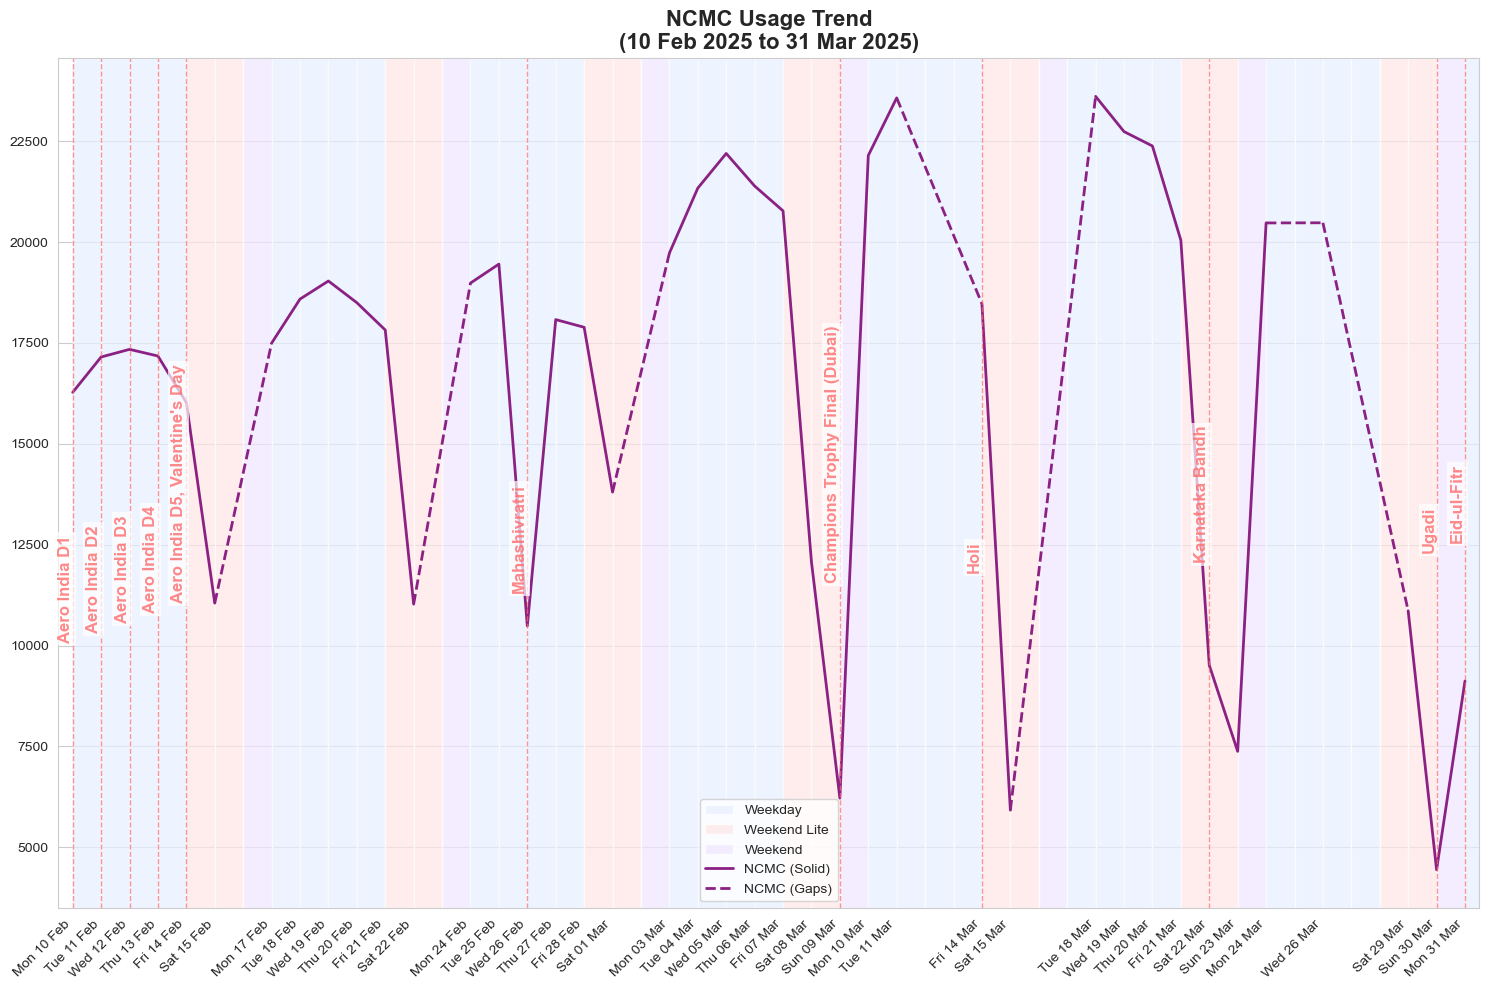

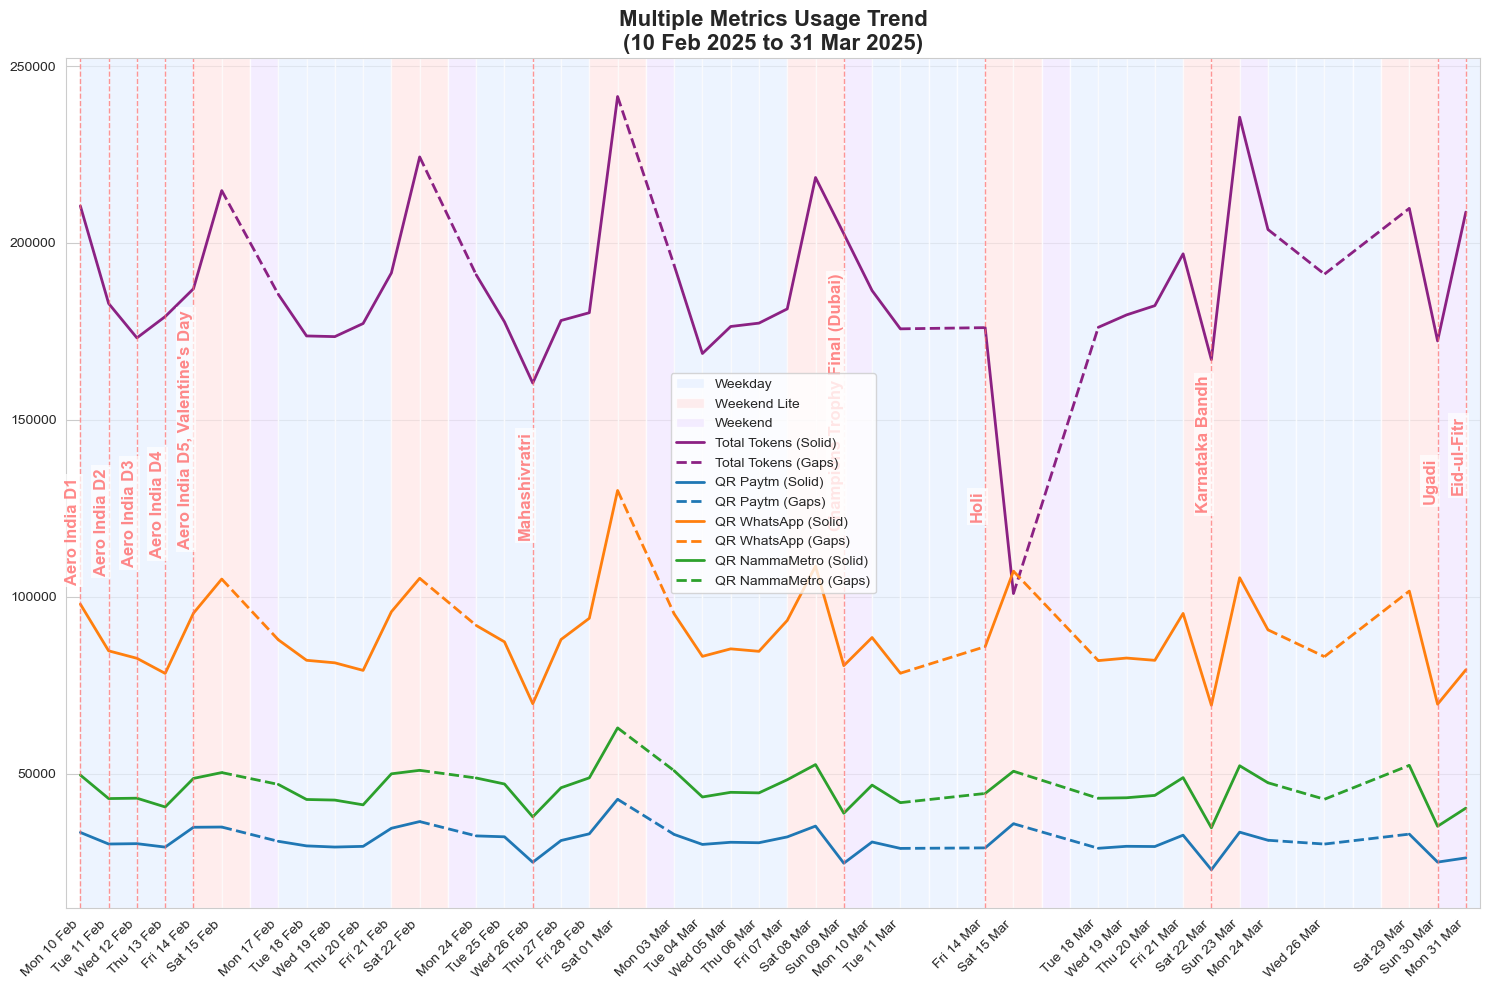

In [306]:
pass_types = ['Tokens', 'Smart Cards']
ax = plot_passes_trend(df2, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=True)

pass_types = ['QR'] # ['Five Day Pass'] + ['Three Day Pass'] + ['One Day Pass']
ax = plot_passes_trend(df2, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=True)

pass_types = ['NCMC']
ax = plot_passes_trend(df2, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=True)

pass_types = ['Total Tokens', 'QR Paytm', 'QR WhatsApp', 'QR NammaMetro']
ax = plot_passes_trend(df, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=True)